In [0]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.impute import SimpleImputer

%matplotlib inline

In [2]:
import os
os.environ['KAGGLE_USERNAME'] = "USERNAME"
os.environ['KAGGLE_KEY'] = "KEY"
!kaggle competitions download -c titanic

train.csv: Skipping, found more recently modified local copy (use --force to force download)
test.csv: Skipping, found more recently modified local copy (use --force to force download)
gender_submission.csv: Skipping, found more recently modified local copy (use --force to force download)


In [0]:
titanic = pd.read_csv("train.csv", index_col = 'PassengerId')
X_test = pd.read_csv('test.csv', index_col='PassengerId')

# Data Comprehension

In [4]:
titanic.head()

,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
PassengerId,,,,,,,,,,,
1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [5]:
titanic.describe()

,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000
mean,0.383838,2.308642,29.699118,0.523008,0.381594,32.204208
std,0.486592,0.836071,14.526497,1.102743,0.806057,49.693429
min,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,0.000000,2.000000,20.125000,0.000000,0.000000,7.910400
50%,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,1.000000,3.000000,38.000000,1.000000,0.000000,31.000000
max,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


In [6]:
titanic.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 891 entries, 1 to 891
Data columns (total 11 columns):
Survived    891 non-null int64
Pclass      891 non-null int64
Name        891 non-null object
Sex         891 non-null object
Age         714 non-null float64
SibSp       891 non-null int64
Parch       891 non-null int64
Ticket      891 non-null object
Fare        891 non-null float64
Cabin       204 non-null object
Embarked    889 non-null object
dtypes: float64(2), int64(4), object(5)
memory usage: 83.5+ KB


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f2f4d44e6d8>,
      dtype=object)

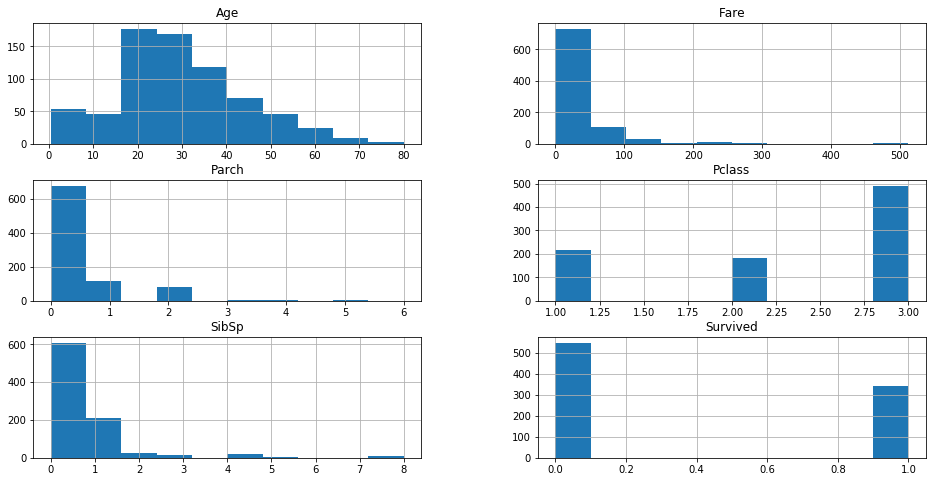

In [7]:
titanic.hist(figsize=(16,8))

## Counting different values in Ticket feature

In [8]:
titanic.Ticket.nunique()

681

## Exploring associations

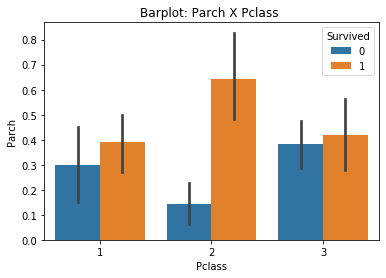

In [9]:
plt.title("Barplot: Parch X Pclass ")
sns.barplot(data=titanic,y='Parch', x='Pclass',hue='Survived')

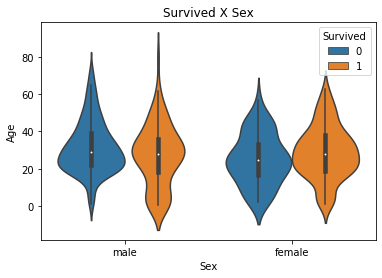

In [10]:
plt.title("Survived X Sex")
sns.violinplot(x='Sex',y='Age',hue='Survived', data=titanic)

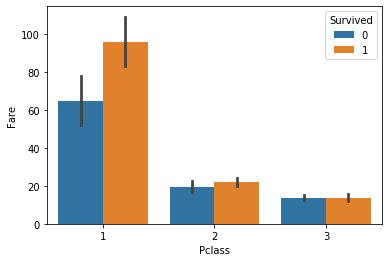

In [11]:
sns.barplot(x='Pclass', y='Fare', hue='Survived', data=titanic)

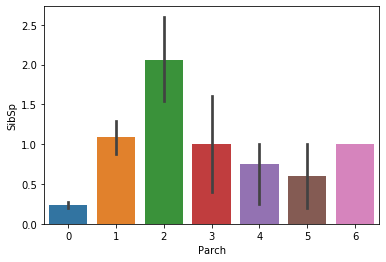

In [12]:
sns.barplot(x='Parch',y='SibSp',data=titanic)

# Preprocessing Data: Drop Useless Columns
*   The three columns cabin, name and ticket are useless because: cabin got more or less 200 values as not null, what means more than 70% of the data are empty; ticket and name got one value per input. 
*   Survived is cutted of because is what we gonna try to predict. Using it to create new features would imply in data leakage.

In [0]:
df = titanic.drop(['Cabin', 'Name', 'Ticket', 'Survived'], axis=1)
X_test = X_test.drop(['Cabin', 'Name', 'Ticket'], axis=1)

In [14]:
df.columns

Index(['Pclass', 'Sex', 'Age', 'SibSp', 'Parch', 'Fare', 'Embarked'], dtype='object')

# Preprocessing Data: Feature Engeneering

In [15]:
df.head()

,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked
PassengerId,,,,,,,
1,3,male,22.0,1,0,7.2500,S
2,1,female,38.0,1,0,71.2833,C
3,3,female,26.0,0,0,7.9250,S
4,1,female,35.0,1,0,53.1000,S
5,3,male,35.0,0,0,8.0500,S


In [16]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 891 entries, 1 to 891
Data columns (total 7 columns):
Pclass      891 non-null int64
Sex         891 non-null object
Age         714 non-null float64
SibSp       891 non-null int64
Parch       891 non-null int64
Fare        891 non-null float64
Embarked    889 non-null object
dtypes: float64(2), int64(3), object(2)
memory usage: 95.7+ KB


In [17]:
df.corr()

,Pclass,Age,SibSp,Parch,Fare
Pclass,1.000000,-0.369226,0.083081,0.018443,-0.549500
Age,-0.369226,1.000000,-0.308247,-0.189119,0.096067
SibSp,0.083081,-0.308247,1.000000,0.414838,0.159651
Parch,0.018443,-0.189119,0.414838,1.000000,0.216225
Fare,-0.549500,0.096067,0.159651,0.216225,1.000000


In [0]:
df['Family_Size'] = df['SibSp'] + df['Parch']
X_test['Family_Size'] = X_test['SibSp'] + X_test['Parch']

In [0]:
df.drop(['SibSp', 'Parch'], axis = 1, inplace = True)
X_test.drop(['SibSp', 'Parch'], axis = 1, inplace = True)

# Preprocessing Data: Creating Pipelines

In [0]:
num_cols = [column for column in df.columns if df[column].dtype in ['float64', 'int64']]
cat_cols = [column for column in df.columns if df[column].dtype not in ['float64', 'int64']]

In [21]:
print('Numeric Columns',num_cols)
print('Categorical Columns',cat_cols)

Numeric Columns ['Pclass', 'Age', 'Fare', 'Family_Size']
Categorical Columns ['Sex', 'Embarked']


In [0]:
num_preprocessing_1 = Pipeline([('imputer', SimpleImputer(strategy='mean')),('scaler', StandardScaler())])

cat_preprocessing_1 = Pipeline([('imputer', SimpleImputer(strategy='most_frequent')),('onehot', OneHotEncoder(handle_unknown='ignore'))])

preprocessor = ColumnTransformer([('numerical', num_preprocessing_1, num_cols), ('categorical', cat_preprocessing_1, cat_cols)], n_jobs=4)

In [0]:
final_df = preprocessor.fit_transform(df)

In [24]:
final_df[0]

array([ 0.82737724, -0.5924806 , -0.50244517,  0.05915988,  0.        ,
        1.        ,  0.        ,  0.        ,  1.        ])

In [0]:
def create_model(preprocess,model):
  return Pipeline([('preprocess', preprocessor),('model', model)])

# Modelling
*   Naive Bayes
*   Random Forest
*   Decision Tree
*   KNN
*   Logistic Regression

In [0]:
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier

In [0]:
X_train = df
y = titanic.Survived

## Naive Bayes

In [0]:
naive_bayes = create_model(preprocessor, GaussianNB())

In [29]:
naive_bayes.fit(X_train,y)
print(naive_bayes.score(X_train, y))

0.7878787878787878


## Random Forest

In [30]:
random_forest = create_model(preprocessor, RandomForestClassifier(max_depth=10, n_jobs = 4))
random_forest.fit(X_train,y)
print(random_forest.score(X_train, y))

0.9450056116722784


#Decision Tree

In [31]:
decision_tree = create_model(preprocessor, DecisionTreeClassifier(max_depth=10))
decision_tree.fit(X_train, y)
print(decision_tree.score(X_train, y))

0.9248035914702581


#KNN

In [32]:
knn = create_model(preprocessor, KNeighborsClassifier(n_neighbors=5))
knn.fit(X_train, y)
print(knn.score(X_train, y))

0.8630751964085297


#Logistic Regression

In [33]:
log_reg = create_model(preprocessor, LogisticRegression())
log_reg.fit(X_train, y)
print(log_reg.score(X_train, y))

0.8035914702581369


#Result

In [0]:
Y_predict = random_forest.predict(X_test)

In [0]:
submission = pd.DataFrame({
    "PassengerId": X_test.index,
    "Survived": Y_predict
})

In [0]:
submission.to_csv('submission.csv')